In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("darkgrid")

import common_functions as cf

In [25]:
ROLL_STEPS = 100

## Import Data

In [26]:
df_all = pd.read_pickle("merged_df.pkl")

# Feature engineering (basic)

In [27]:
df_fe = cf.fe_basic_features(df_all)

# Feature engineering (Rolling)
rolling function takes an amount of directly preceding values to generate stuff like mean, median etc. So for my later input data, I don't need anything else than a set of preceding motion data.

In [28]:
roll_df =  cf.fe_roll_features(df_fe,ROLL_STEPS)

In [29]:
len(roll_df.columns)

31

## Data Splitting

In [30]:
train_df_roll,test_df_roll = cf.data_split_TrainTest(roll_df)

In [31]:
X_train_roll,y_train_roll = cf.data_split_FeatLabel(train_df_roll)
X_test_roll,y_test_roll = cf.data_split_FeatLabel(test_df_roll)

## Modeling

### Random ForestClassifier (baseline)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

roll_rfc = RandomForestClassifier(n_estimators=100,max_depth=4)
roll_rfc.fit(X_train_roll, y_train_roll)

RandomForestClassifier(max_depth=4)

In [33]:
print(f" The acurracy for Train data is: {round(accuracy_score(y_train_roll,roll_rfc.predict(X_train_roll))*100,3)} %")

 The acurracy for Train data is: 84.682 %


In [34]:
print(f" The acurracy for Test data is: {round(accuracy_score(y_test_roll,roll_rfc.predict(X_test_roll))*100,3)} %")


 The acurracy for Test data is: 84.402 %


### Neurel Network

In [47]:
from tensorflow import keras
from tensorflow.keras.models import Sequential,load_model

from tensorflow.keras.layers import Dense
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from keras.layers import Dropout


In [48]:
input_dim = X_train_roll.shape[1]
cnn = Sequential()
cnn.add(Dense(80, input_dim=input_dim, activation='relu'))
#cnn.add(Dropout(0.2))
cnn.add(Dense(40, activation='relu'))
cnn.add(Dense(20, activation='relu'))
#cnn.add(Dropout(0.5))
cnn.add(Dense(1, activation='sigmoid'))

In [49]:
print(cnn.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 80)                2320      
                                                                 
 dense_9 (Dense)             (None, 40)                3240      
                                                                 
 dense_10 (Dense)            (None, 20)                820       
                                                                 
 dense_11 (Dense)            (None, 1)                 21        
                                                                 
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
opt = keras.optimizers.Adam(learning_rate=0.01)

cnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [51]:
X_train_arr = np.asarray(X_train_roll)
y_train_arr = np.asarray(y_train_roll)
X_test_arr = np.asarray(X_test_roll)
y_test_arr = np.asarray(y_test_roll)

In [52]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [53]:
history = cnn.fit(X_train_arr, y_train_arr, epochs=100, batch_size=250,callbacks=[es,mc]
                  ,validation_split=0.2)


Epoch 1/100
93/94 [============================>.] - ETA: 0s - loss: 0.5934 - accuracy: 0.6890
Epoch 1: val_accuracy improved from -inf to 0.71331, saving model to best_model.h5
94/94 [==============================] - 4s 16ms/step - loss: 0.5931 - accuracy: 0.6891 - val_loss: 0.5387 - val_accuracy: 0.7133
Epoch 2/100
87/94 [==========================>...] - ETA: 0s - loss: 0.4207 - accuracy: 0.7898
Epoch 2: val_accuracy improved from 0.71331 to 0.78798, saving model to best_model.h5
94/94 [==============================] - 1s 10ms/step - loss: 0.4157 - accuracy: 0.7937 - val_loss: 0.4615 - val_accuracy: 0.7880
Epoch 3/100
93/94 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8638
Epoch 3: val_accuracy did not improve from 0.78798
94/94 [==============================] - 1s 9ms/step - loss: 0.3020 - accuracy: 0.8641 - val_loss: 0.5633 - val_accuracy: 0.7715
Epoch 4/100
92/94 [============================>.] - ETA: 0s - loss: 0.2293 - accuracy: 0.9006
Epoch 4: va

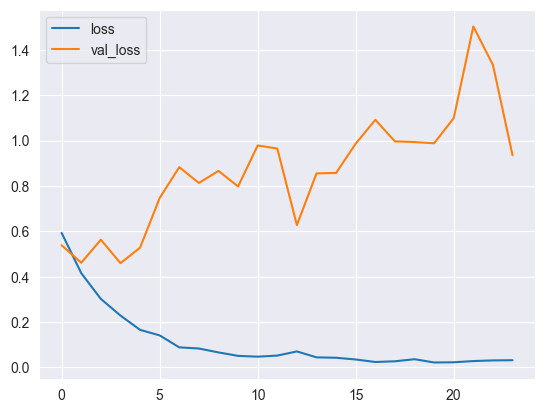

In [54]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss',"val_loss"]].plot()
plt.show()

#### Evaluation

- Evaluate best model which was monitored and saved

In [55]:
best_saved_model = load_model('best_model.h5')
_, train_acc = best_saved_model.evaluate(X_train_arr, y_train_arr, verbose=0)
_, test_acc = best_saved_model.evaluate(X_test_arr, y_test_arr, verbose=0)
print('Train: %.2f, Test: %.2f' % (train_acc*100, test_acc*100))

Train: 95.39, Test: 80.02


In [56]:
from sklearn.metrics import mean_absolute_error
best_model_predictions = best_saved_model.predict(X_test_arr)
mae = round(mean_absolute_error(y_test_roll, best_model_predictions),3)
print("mean absolute error is",mae)

745/745 [==============================] - 4s 4ms/step
mean absolute error is 0.205


In [57]:
# convert predicted label rom analog to binary value
bin_best_model_predictions=[]
for val in best_model_predictions:
    if val >=0.5:
        bin_best_model_predictions.append(1)
    else:
        bin_best_model_predictions.append(0)

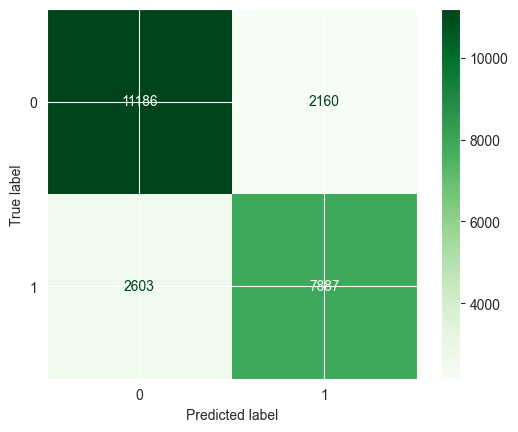

In [58]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(bin_best_model_predictions, y_test_roll)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
conf_mat_disp.plot(cmap='Greens')
plt.show()